In [1]:

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as  pd
import numpy as np
import math
import time
from tqdm import tqdm
import os
sns.set_context("paper", rc={"axes.labelsize":40})
if os.path.isdir("model/")==False:
    os.mkdir('model')
num_epochs=20
batch_size=64


In [2]:
tf.set_random_seed(100)
class model():
    def __init__(self):
        with tf.Graph().as_default():
            self.x=tf.placeholder(tf.float32,shape=[None,784])
            self.labels=tf.placeholder(tf.int32,shape=[None])
            
            #network
            self.layer1=tf.layers.dense(self.x,1000,activation=tf.nn.relu,use_bias=False,kernel_initializer='glorot_uniform')
            self.layer2=tf.layers.dense(self.layer1,1000,activation=tf.nn.relu,use_bias=False,kernel_initializer='glorot_uniform')
            self.layer3=tf.layers.dense(self.layer2,500,activation=tf.nn.relu,use_bias=False,kernel_initializer='glorot_uniform')
            self.layer4=tf.layers.dense(self.layer3,200,activation=tf.nn.relu,use_bias=False,kernel_initializer='glorot_uniform')
            self.logits=tf.layers.dense(self.layer4,10,use_bias=False,kernel_initializer='glorot_uniform')
            self.probs=tf.nn.softmax(self.logits,axis=1)
            
            
            self.loss=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.labels,logits=self.logits)
            self.loss=tf.reduce_mean(self.loss)
            
            self.trainable_vars=tf.trainable_variables()#holds trainable variables for pruning
            self.varstosparsify=self.trainable_vars[:-1]#no pruning for last layer
            self.last_layer=self.trainable_vars[-1]
            
            
            self.sparsified_weights=[]#to hold sparse weights       
            self.pruned_weights=[]#to hold dense pruned weights
            
            self.opt=tf.train.AdamOptimizer().minimize(self.loss)
            self.saver=tf.train.Saver()
            self.graph=tf.get_default_graph()   
    def weightpruneeager(self,weight,percentile):  
        #this function is used for weight pruning
        weight_numpy=weight.numpy()
        val=np.percentile(np.abs(weight_numpy),percentile)#calculating value below which all weights are to be zeroed
        condition=tf.greater_equal(tf.abs(weight),val)
        indices=tf.where(condition)#indices of weights to keep
        values=tf.gather_nd(weight,indices)#values of weights to keep
        shape=tf.shape(weight,out_type=tf.int64)
        sparsetensor=tf.sparse.SparseTensor(indices,values,shape)
        densetensor=tf.sparse.to_dense(sparsetensor)
        self.pruned_weights.append(densetensor)#add dense tensors
        self.sparsified_weights.append(sparsetensor)#add sparsified tensors 
        return densetensor
    def unitpruneeager(self,weight,percentile):
        #this function is used for unit pruning
        weight_numpy=weight.numpy()
        col_norm = np.linalg.norm(weight_numpy, axis=0)#get l2 norm of each column
        val= np.percentile(col_norm, percentile)#calaculating value above which each column we have to keep
        mask=col_norm<val#get the mask
        weight_numpy[:,mask]=0
        weight=tf.convert_to_tensor(weight_numpy)
        self.pruned_weights.append(weight)#add dense tensors
        self.sparsified_weights.append(tf.contrib.layers.dense_to_sparse(weight))#add sparsified tensors 
        return weight_numpy
    def sparseevaluateeager(self,x):
        #evaluating the model using sparse matrix multiplications
        #no transpose is required as the transposed matrix is sent from feed_dict
        #the returned result is (10,batch_size)
        sparsed_weights=self.sparsified_weights
        a1=tf.nn.relu(tf.sparse.matmul(sparsed_weights[0],x,adjoint_a=True))
        a2=tf.nn.relu(tf.sparse.matmul(sparsed_weights[1],a1,adjoint_a=True))
        a3=tf.nn.relu(tf.sparse.matmul(sparsed_weights[2],a2,adjoint_a=True))
        a4=tf.nn.relu(tf.sparse.matmul(sparsed_weights[3],a3,adjoint_a=True))
        preds=tf.matmul(tf.convert_to_tensor(sparsed_weights[4]),a4)
        return preds
    def denseevaluateeager(self,x):
        #evaluating the model using pruned weights and normal matmul
        #the returned result is (batch_size,10)
        pruned_weights=self.pruned_weights
        a1=tf.nn.relu(tf.matmul(x,pruned_weights[0]))
        a2=tf.nn.relu(tf.matmul(a1,pruned_weights[1]))
        a3=tf.nn.relu(tf.matmul(a2,pruned_weights[2]))
        a4=tf.nn.relu(tf.matmul(a3,pruned_weights[3]))
        preds=tf.matmul(a4,tf.convert_to_tensor(pruned_weights[4]))
        return preds
    def getloss(self,probs,y):
        loss=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=probs)
        loss=tf.reduce_mean(loss)
        return loss
        

     



In [3]:
model=model()

In [4]:
#getting the dataset
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32).reshape((-1,1))
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32).reshape((-1,1))
print(train_labels.shape)

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(55000, 1)


In [5]:
#shuffle the dataset
train=np.concatenate((train_data,train_labels),axis=1)
eval=np.concatenate((eval_data,eval_labels),axis=1)
np.random.shuffle(train)
np.random.shuffle(eval)


In [6]:
#split dataset into batches
train_batches=np.array_split(train,math.ceil(train.shape[0]/batch_size),axis=0)
eval_batches=np.array_split(eval,math.ceil(eval.shape[0]/batch_size),axis=0)


In [7]:
#function to get number of correctly classified instances of the current batch
def checkequal(p,a,axis=1):
    p=np.argmax(p,axis=axis)
    if axis==0: p=p.T
    return np.sum(p==a)

  0%|          | 0/860 [00:00<?, ?it/s]

0 loss:0.20881616806470638 train_acc:0.9361090909090909 test_acc:0.9633


  0%|          | 0/860 [00:00<?, ?it/s]

1 loss:0.09531203050919007 train_acc:0.9721090909090909 test_acc:0.9727


  5%|▌         | 47/860 [00:00<00:01, 464.33it/s]

2 loss:0.06849819612966818 train_acc:0.9793090909090909 test_acc:0.9736


  5%|▌         | 46/860 [00:00<00:01, 455.49it/s]

3 loss:0.05017217468855453 train_acc:0.985 test_acc:0.9734


100%|██████████| 860/860 [00:02<00:00, 313.42it/s]


4 loss:0.04307720502100744 train_acc:0.9868545454545454 test_acc:0.9746


  5%|▍         | 40/860 [00:00<00:02, 393.86it/s]

5 loss:0.039632192031066826 train_acc:0.9881636363636364 test_acc:0.9813


  6%|▌         | 48/860 [00:00<00:01, 477.89it/s]

6 loss:0.03192505675499909 train_acc:0.9908 test_acc:0.977


  5%|▌         | 46/860 [00:00<00:01, 451.21it/s]

7 loss:0.029354006354468616 train_acc:0.9915272727272727 test_acc:0.9812


  5%|▌         | 47/860 [00:00<00:01, 463.41it/s]

8 loss:0.02441913649999426 train_acc:0.9927636363636364 test_acc:0.9781


  5%|▌         | 47/860 [00:00<00:01, 468.75it/s]

9 loss:0.024356506027477864 train_acc:0.9929454545454546 test_acc:0.9772


  5%|▌         | 43/860 [00:00<00:01, 428.03it/s]

10 loss:0.0234526045243054 train_acc:0.9935818181818182 test_acc:0.9762


  5%|▍         | 42/860 [00:00<00:01, 417.95it/s]

11 loss:0.020096512194034 train_acc:0.9943636363636363 test_acc:0.9812


100%|██████████| 860/860 [00:02<00:00, 312.12it/s]


12 loss:0.019923394215068183 train_acc:0.9940181818181818 test_acc:0.9801


  5%|▍         | 39/860 [00:00<00:02, 381.19it/s]

13 loss:0.017862842061187916 train_acc:0.9950545454545454 test_acc:0.9818


  5%|▍         | 42/860 [00:00<00:02, 407.79it/s]

14 loss:0.01818138308976668 train_acc:0.9951272727272727 test_acc:0.9805


  5%|▌         | 44/860 [00:00<00:01, 428.02it/s]

15 loss:0.012397963573360074 train_acc:0.9965272727272727 test_acc:0.977


  5%|▌         | 44/860 [00:00<00:01, 439.95it/s]

16 loss:0.01797564381961484 train_acc:0.9954 test_acc:0.9807


  5%|▍         | 42/860 [00:00<00:01, 413.42it/s]

17 loss:0.015797260605547418 train_acc:0.9958727272727272 test_acc:0.9756


  5%|▌         | 44/860 [00:00<00:01, 437.66it/s]

18 loss:0.00936821625913254 train_acc:0.9972545454545455 test_acc:0.9828


100%|██████████| 860/860 [00:02<00:00, 320.92it/s]


19 loss:0.015484482966638607 train_acc:0.996 test_acc:0.9821


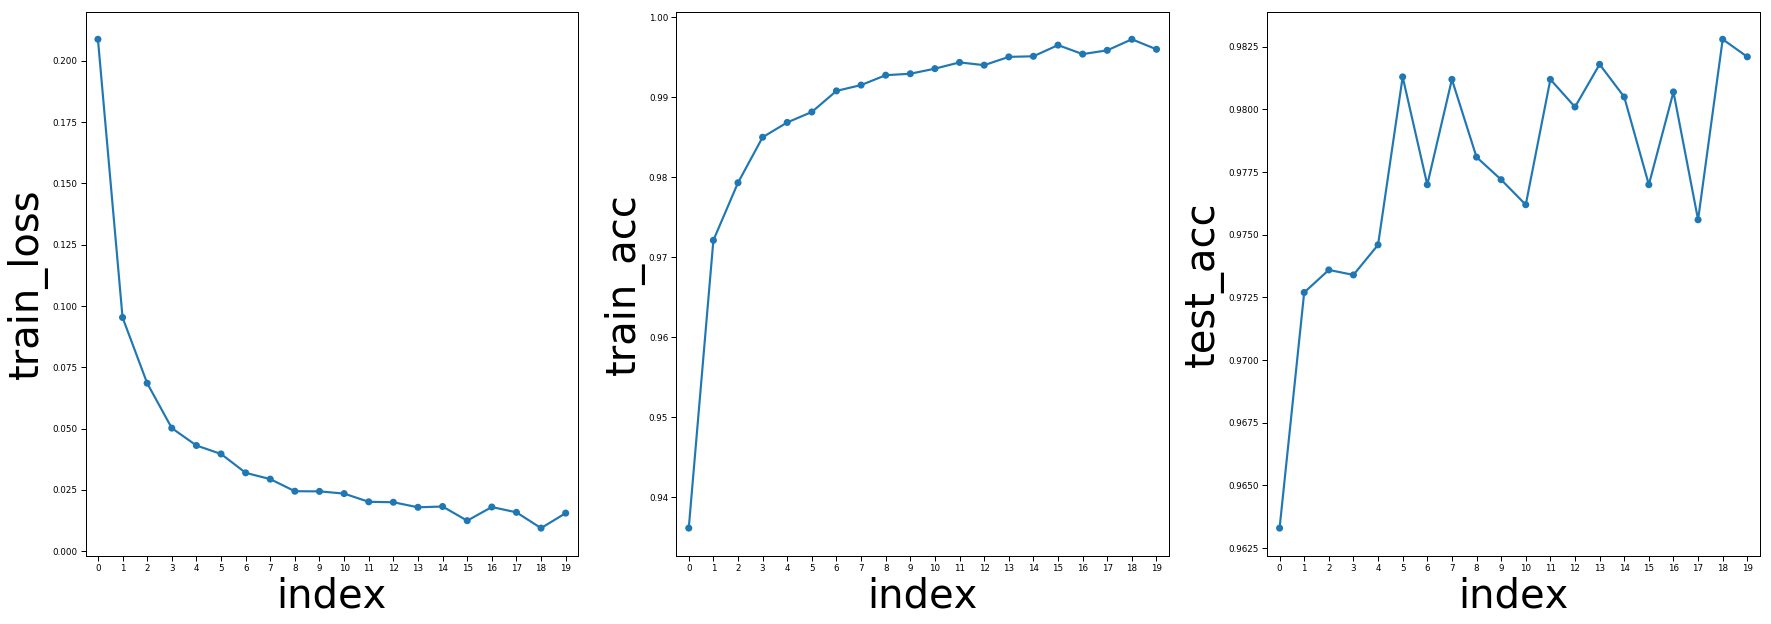

In [8]:
config = tf.ConfigProto(allow_soft_placement = True)
config.gpu_options.allow_growth = True
train_stats={}
train_stats['index']=[]
train_stats['train_loss']=[]
train_stats['test_acc']=[]
train_stats['train_acc']=[]
with tf.Session(config=tf.ConfigProto(log_device_placement=True),graph=model.graph) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_epochs):
        train_stats['index'].append(i)
        
        ls=0
        train_correct=0
        train_total=0
        for batch in tqdm(train_batches):
            data,y=batch[:,:-1],batch[:,-1]
            y=y.astype(np.int32)
            l,_,p=sess.run([model.loss,model.opt,model.probs],feed_dict={model.x:data,model.labels:y})
            train_correct+=checkequal(p,y)
            train_total+=y.shape[0]
            ls+=l
        
        ls=ls/len(train_batches)
        train_acc=float(train_correct)/float(train_total)
        train_stats['train_loss'].append(ls)
        train_stats['train_acc'].append(train_acc)
        
        test_correct=0
        test_total=0
        for batch in eval_batches:
            data,y=batch[:,:-1],batch[:,-1]
            p=sess.run(model.probs,feed_dict={model.x:data})
            test_correct+=checkequal(p,y)
            test_total+=y.shape[0]
        
        test_acc=float(test_correct)/float(test_total)
        train_stats['test_acc'].append(test_acc)
        print(str(i)+' loss:'+str(ls)+' train_acc:'+str(train_acc)+' test_acc:'+str(test_acc))
        #save model 
        model.saver.save(sess,'model/model.pb')
train_df=pd.DataFrame(train_stats)
fig, axs = plt.subplots(ncols=3,figsize=(30,10))
ax1=sns.pointplot(x='index',y='train_loss',data=train_df,ax=axs[0])
ax2=sns.pointplot(x='index',y='train_acc',data=train_df,ax=axs[1])
ax3=sns.pointplot(x='index',y='test_acc',data=train_df,ax=axs[2])

INFO:tensorflow:Restoring parameters from model/model.pb


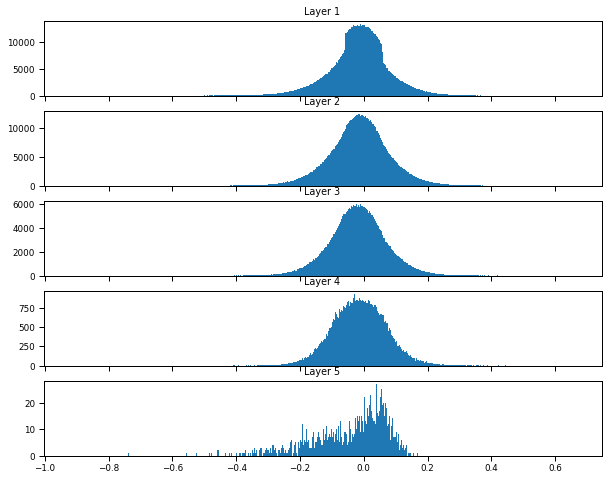

In [9]:
#plotting distribution of weights for each weight
config = tf.ConfigProto(allow_soft_placement = True)
config.gpu_options.allow_growth = True
with tf.Session(config=config,graph=model.graph) as sess:
    model.saver.restore(sess,'model/model.pb')
    f,ax=plt.subplots(5,1,sharex=True,figsize=(10,8))
    for i, weights in enumerate(model.trainable_vars):
        ax[i].hist(sess.run(weights).reshape(-1), bins=500)
        ax[i].set_title("Layer "+str(i+1))
        
        

INFO:tensorflow:Restoring parameters from model/model.pb


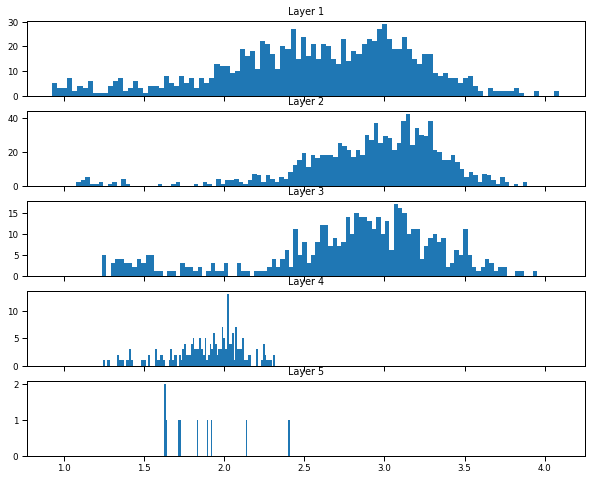

In [10]:
#plotting distribution of column norms for each weight
config = tf.ConfigProto(allow_soft_placement = True)
config.gpu_options.allow_growth = True
with tf.Session(config=config,graph=model.graph) as sess:
    model.saver.restore(sess,'model/model.pb')
    f,ax=plt.subplots(5,1,sharex=True,figsize=(10,8))
    for i, weights in enumerate(model.trainable_vars):
        weight_numpy=sess.run(weights)
        weight_numpy_norm=np.linalg.norm(weight_numpy,axis=0)
        ax[i].hist(weight_numpy_norm, bins=100)
        ax[i].set_title("Layer "+str(i+1))

In [11]:
k=[0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

In [12]:
tfe = tf.contrib.eager #for eager execution

In [13]:
def sparsedensecompare(eval_time_data,eval_data,p):
    #this function is used for evaluating the pruned weights on the test set.
    #both the pruned (zeroed out but dense) and sparsified weights are evaluated and the timings are compared 
    time_sparse=time.clock()
    with tf.Session(config=config,graph=model.graph) as sess:
            test_correct=0
            test_total=0
            x=tf.placeholder(tf.float32)
            #tfe.py_func() Wraps a python function into a TensorFlow op that executes it eagerly 
            sparseevaluate_func=tfe.py_func(model.sparseevaluateeager,[x],tf.float32)
            
            #evaluating on test set using sparsed weights
            for batch in eval_batches:
                data,y=batch[:,:-1],batch[:,-1]  
                preds_sparse=sess.run(sparseevaluate_func,feed_dict={x:data.T})
                test_correct+=checkequal(preds_sparse,y,axis=0)
                test_total+=y.shape[0]
                
                
    time_sparse=time.clock()-time_sparse
    test_acc_sparse=float(test_correct)/float(test_total)
    eval_time_data['time'].append(time_sparse)
    eval_time_data['category'].append('sparse')
    
    
    time_dense = time.clock()
    with tf.Session(config=config,graph=model.graph) as sess:       
            test_correct=0
            test_total=0
            x=tf.placeholder(tf.float32)
            denseevaluate_func=tfe.py_func(model.denseevaluateeager,[x],tf.float32)
            
            #evaluating on test set using dense weights (pruned)
            for batch in eval_batches:
                data,y=batch[:,:-1],batch[:,-1]
                preds_dense=sess.run(denseevaluate_func,feed_dict={x:data})
                test_correct+=checkequal(preds_dense,y,axis=1)
                test_total+=y.shape[0]
    
            
    time_dense = time.clock()-time_dense
    test_acc_dense=float(test_correct)/float(test_total)
    assert test_acc_dense==test_acc_sparse
    eval_data['acc'].append(test_acc_dense)
    eval_time_data['time'].append(time_dense)
    eval_time_data['category'].append('dense')
    
    with tf.Session(config=config,graph=model.graph) as sess:
        x=tf.placeholder(tf.float32)
        labels=tf.placeholder(tf.int32)
        logits=tf.placeholder(tf.float32)
        denseevaluate_func=tfe.py_func(model.denseevaluateeager,[x],tf.float32)
        loss_func=tfe.py_func(model.getloss,[logits,labels],tf.float32)
        #calculating loss for pruned weights on the test set
        test_ls=0
        for batch in eval_batches:
            data,y=batch[:,:-1],batch[:,-1]
            preds_dense=sess.run(denseevaluate_func,feed_dict={x:data})     
            ls=sess.run(loss_func,feed_dict={labels:y,logits:preds_dense})
            test_ls+=ls/len(eval_batches)
        eval_data['loss'].append(test_ls)
    print('k:'+str(p)+' test_acc:'+str(test_acc_dense)+' time_sparse:'+str(time_sparse)+ ' time_dense:'+str(time_dense)+' test_loss:'+str(test_ls))
    
    
    
    
    

# WEIGHT PRUNING

INFO:tensorflow:Restoring parameters from model/model.pb
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
k:0 test_acc:0.9821 time_sparse:0.894479000000004 time_dense:1.009053999999992 test_loss:0.11499496816618433
INFO:tensorflow:Restoring parameters from model/model.pb
k:25 test_acc:0.9816 time_sparse:0.9149230000000017 time_dense:0.7290979999999934 test_loss:0.11322243970274135
INFO:tensorflow:Restoring parameters from model/model.pb
k:50 test_acc:0.982 time_sparse:0.7929189999999977 time_dense:1.1279719999999998 test_loss:0.09860794342635049
INFO:tensorflow:Restoring parameters from model/model.pb
k:60 test_acc:0.9813 time_sparse:0.7487940000000037 time_dense:1.126076999999995 test_loss:0.08989809629496054
INFO:tensorflow:Restoring parameters from model/model.pb
k:70 test_acc:0.9799 time_sparse:0.750189000000006 time_dense:1.2673489999999958 test_loss:0.08279760237071354
INFO:tensorflow:Restoring parameters from model/model.pb
k:80 

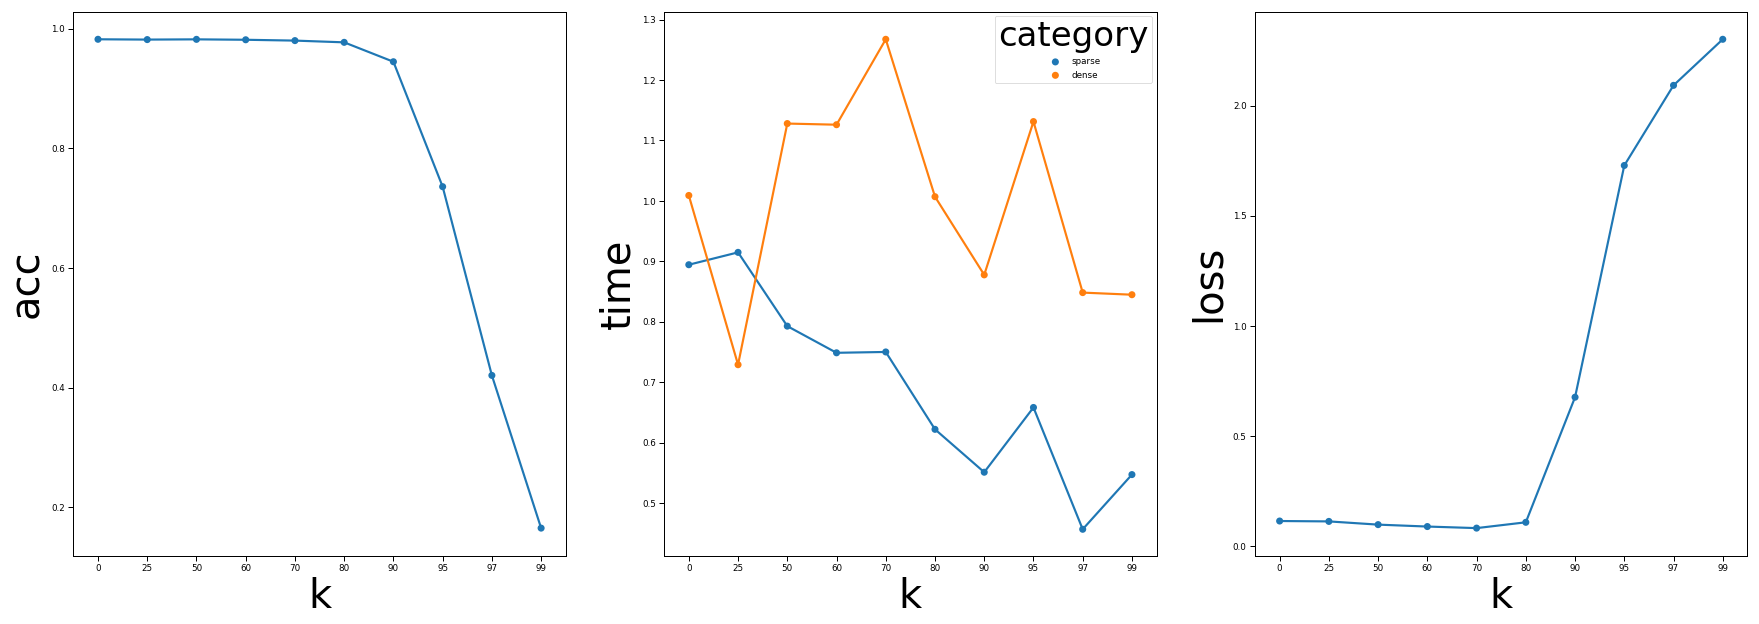

In [14]:
#dictionaries used to store stats for evaluation such as time and accuracy.
eval_time_data={}
eval_time_data['k']=[]
eval_time_data['time']=[]
eval_time_data['category']=[]
eval_data={}
eval_data['k']=[]
eval_data['acc']=[]
eval_data['loss']=[]

for p in k:
    
    eval_data['k'].append(p)
    eval_time_data['k'].append(p)
    eval_time_data['k'].append(p)
    config = tf.ConfigProto(allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    
    with tf.Session(config=config,graph=model.graph) as sess:
        #retore the not pruned model
        model.saver.restore(sess,'model/model.pb')
        model.sparsified_weights=[]
        model.pruned_weights=[]
        percentile=tf.placeholder(tf.float32)
        wt=tf.placeholder(tf.float32)
        
        #each weight is pruned using the weightpruneeager function defined in the model
        weight_prune_func=tfe.py_func(model.weightpruneeager,[wt,percentile],[tf.float32])
        for v in model.varstosparsify:
            w=sess.run(v)
            
            #get each weight to be pruned as numpy array and feed it into the eager function (weightpruneeager)  for pruning
            sp=sess.run(weight_prune_func,feed_dict={wt:w,percentile:p})
        #get last layer as is 
        last_layer=sess.run(model.last_layer)
        model.sparsified_weights.append(last_layer.T)
        model.pruned_weights.append(last_layer)
    
    sparsedensecompare(eval_time_data,eval_data,p)

eval_time_df=pd.DataFrame(eval_time_data)
eval_df=pd.DataFrame(eval_data)
fig, axs = plt.subplots(ncols=3,figsize=(30,10))

ax1=sns.pointplot(x='k',y='acc',data=eval_df,ax=axs[0])
ax2=sns.pointplot(x='k',y='time',hue='category',data=eval_time_df,ax=axs[1])
ax3=sns.pointplot(x='k',y='loss',data=eval_df,ax=axs[2])

# unit pruning

In [ ]:
#dictionaries used to store stats for evaluation such as time and accuracy.
eval_time_data={}
eval_time_data['k']=[]
eval_time_data['time']=[]
eval_time_data['category']=[]
eval_data={}
eval_data['k']=[]
eval_data['acc']=[]
eval_data['loss']=[]
for p in k:
    eval_data['k'].append(p)
    eval_time_data['k'].append(p)
    eval_time_data['k'].append(p)
    config = tf.ConfigProto(allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    
    with tf.Session(config=config,graph=model.graph) as sess:
        #restore the not pruned model
        model.saver.restore(sess,'model/model.pb')
        model.sparsified_weights=[]
        model.pruned_weights=[]
        percentile=tf.placeholder(tf.float32)
        wt=tf.placeholder(tf.float32)
        unit_prune_func=tfe.py_func(model.unitpruneeager,[wt,percentile],[tf.float32])
        #each weight is pruned using the unitpruneeager function defined in the model
        for v in model.varstosparsify:
            w=sess.run(v)
            #get each weight to be pruned as numpy array and feed it into the eager function (unitpruneeager)  for pruning
            sp=sess.run(unit_prune_func,feed_dict={wt:w,percentile:p})
        #get last layer as is 
        last_layer=sess.run(model.last_layer)
        model.sparsified_weights.append(last_layer.T)
        model.pruned_weights.append(last_layer)
    
    sparsedensecompare(eval_time_data,eval_data,p)
eval_time_df=pd.DataFrame(eval_time_data)
eval_df=pd.DataFrame(eval_data)
fig, axs = plt.subplots(ncols=3,figsize=(30,10))
ax1=sns.pointplot(x='k',y='acc',data=eval_df,ax=axs[0])
ax2=sns.pointplot(x='k',y='time',hue='category',data=eval_time_df,ax=axs[1])
ax3=sns.pointplot(x='k',y='loss',data=eval_df,ax=axs[2])

INFO:tensorflow:Restoring parameters from model/model.pb
k:0 test_acc:0.9821 time_sparse:0.8237680000000012 time_dense:0.8972479999999905 test_loss:0.11499496816618433
INFO:tensorflow:Restoring parameters from model/model.pb
k:25 test_acc:0.9814 time_sparse:0.9312630000000013 time_dense:0.9992620000000159 test_loss:0.08391173493630491
INFO:tensorflow:Restoring parameters from model/model.pb
k:50 test_acc:0.978 time_sparse:0.823235000000011 time_dense:1.3053010000000143 test_loss:0.08337834614008713
INFO:tensorflow:Restoring parameters from model/model.pb
k:60 test_acc:0.9751 time_sparse:0.727768999999995 time_dense:0.5652149999999949 test_loss:0.18868541665327787
INFO:tensorflow:Restoring parameters from model/model.pb
k:70 test_acc:0.8876 time_sparse:0.7493840000000205 time_dense:1.0228219999999908 test_loss:0.5336698781532848
INFO:tensorflow:Restoring parameters from model/model.pb
k:80 test_acc:0.7008 time_sparse:0.6326660000000004 time_dense:0.721209999999985 test_loss:1.3691849199

# Insights

I have implemented the weight pruning and unit pruning methods. It was observed that to have good performance after pruning the final distributions of the weights are really important. The final distributions of the weights depends a lot on the learning rate. The initial learning rate used was 1e-5. In this case, the final accuracy, after training(20 epochs) was ~98%. But, It was observed that the distributions of the weights had a flat top. In this case, the test accuracy dropped very early (smaller values of k) in the case of weight as well as unit pruning. The learning rate was then increased to 0.001 and the final accuracy after training was ~98%. In this case it was observed that the distributions of the weight matrices were proper gaussians. In this case the the accuracies didn't drop for early values of k (accuracies did not degrade rapidly  with increasing k) and the performance was much better.

It was also observed that the test accuracy initially increases a little bit in weight pruning. This shows that the network overfits the training set. Pruning thus has a regularizing effect and it decreases the generalization error. Though fundamentally different, L1 regularization also leads to a sparse solution. I believe the main intuition behind pruning is that weights with small magnitudes don't have much effect on the outputs. The weight distribution above also shows that the majority of the weights have extremely small values hence zeroing them doesn't have much effect. [This paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6288897) shows that ~70% of the weights of the neural network are small and can be removed.

Unit pruning performs worse than weight pruning. In unit pruning we zero out entire columns, which results in zeroing out of the output neuron. We are essentially removing certain features which are essential for classification. Initially, we remove those features that are not so important hence performance doesn't decrease. As k increases, we remove more important features and performance degrades more rapidly. We can also see that the column norms have lesser values with lower magnitudes hence its performance degrades faster.

Another thought about this can be that the network learns redundant features. Hence we can remove some features(or even weights) without having any effect. Though this is unlikely since we are removing features based on magnitude, this may be one of the things that has some contribution to achieve the observed result.

We can see that the sparse evaluation is faster than dense evaluation for both unit pruning and weight pruning. As the sparsity increases, the evaluation time (of sparse evaluaton) decreases. 

